<a href="https://www.kaggle.com/code/m000sey/ps-3-24-boosting-ensemble-w-nn?scriptVersionId=151174484" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

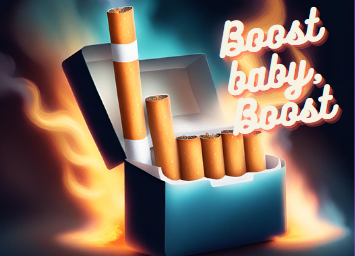

<a id="table"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table of contents</span>

[1. Overview](#1)

[2. Feature engineering](#2)

[3. Modeling](#3)

[3a. Neural network](#4)
    
[3b. Boosts and Trees](#5)

[4. Submission form](#6)

<a id="1"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;"> Overview </span>
> **1.** Add a gender feature, which from discussions has been shown to A) be accurate, and B) have high SHAP values

> **2.** Ensemble several models: NN, XGB, CAT, LGBM, HGB, and RF via blending

> **3.** Engineer some features to put into the NN, and run the NN

> **4.** Run the Boost part of the ensemble

> **5.** Blend the model's output

> **6.** Submit

In [1]:
### Import libraries and select file path
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import yeojohnson
import platform
import os
from catboost import CatBoostClassifier
import catboost
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import time 

start_time = time.time()

if platform.system() == "Windows":
    train_path =  'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/smoker_status/train.csv'
    test_path =   'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/smoker_status/test.csv'
    sample_path = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/smoker_status/sample_submission.csv'
    gender_path = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/smoker_status/smoking_gender.csv'
    print("Using Windows file path...")
elif platform.system() == "Darwin":
    train_path = '/Users/shane/Documents/data_science/train.csv'
    test_path =  '/Users/shane/Documents/data_science/test.csv'
    print("Using Mac file path...")
elif platform.system() == "Linux":
    train_path =  '/kaggle/input/playground-series-s3e24/train.csv'
    test_path =   '/kaggle/input/playground-series-s3e24/test.csv'
    sample_path = '/kaggle/input/playground-series-s3e24/sample_submission.csv'
    gender_path = '/kaggle/input/body-signal-of-smoking/smoking.csv'
    print("Using Linux file path...")
else:
    raise OSError("Unsupported operating system")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)
gender = pd.read_csv(gender_path)

X = train.iloc[:, 1:-1]
y = train['smoking']
z = test.iloc[:, 1:]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using Linux file path...


In [2]:
print(X)

        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        55         165          60       81.0             0.5   
1        70         165          65       89.0             0.6   
2        20         170          75       81.0             0.4   
3        35         180          95      105.0             1.5   
4        30         165          60       80.5             1.5   
...     ...         ...         ...        ...             ...   
159251   40         155          45       69.0             1.5   
159252   50         155          75       82.0             1.0   
159253   40         160          50       66.0             1.5   
159254   50         165          75       92.0             1.2   
159255   40         145          45       76.4             1.0   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0                   0.6              1               1       135          87   
1                   0.7              2         

<a id="2"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Feature Engineering</span>
- **Note:** From the beginning of this competition, I was curious how to implement gender into this dataset. Alas, @siukeitin figured out a way by doing XGB on a different, but almost identical dataset. 
- **Note:** This is not only important because others like @paddykb found great SHAP scores for it, but also, there're lots of interesting features that ought to be gender dependent, e.g. BMR. I won't implement any more features for this version, but keep your eyes peeled -- I will add more features. 

In [3]:
# Let's predict Gender
# Reference from discussion: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/452379

X_gender = gender.drop(['gender','oral','tartar','smoking'],axis=1)
X_gender = X_gender.iloc[:, 1:]
y_gender = gender['gender'].map({'F':0,'M':1})

kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=5)

gender_results = cross_validate(XGBClassifier(random_state=42,n_jobs=4),
                                              X_gender,y_gender,
                                              scoring='roc_auc',
                                              cv=kfold,n_jobs=1,
                                              return_estimator=True)

gender_results['test_score'].mean(), gender_results['test_score'].std()

(0.9973799959130314, 0.00037267404334729356)

In [4]:
# For training data
X['gender'] = 0
cols = list(z.columns)
for clf in gender_results['estimator']:
    X['gender'] += clf.predict_proba(X[cols])[:,1]
X['gender'] /= len(gender_results['estimator'])
# For testing data
z['gender'] = 0
for clf in gender_results['estimator']:
    z['gender'] += clf.predict_proba(z[cols])[:,1]
z['gender'] /= len(gender_results['estimator'])

# Some feature engineering
CAT_COLS = ['dental caries', 'Urine protein', 'hearing(right)', 'hearing(left)']
NUM_COLS = [col for col in X.columns if col not in CAT_COLS]

def nn_feature_engineering(df):
    # 9.9 means blindness
    df['eyesight(left)'] = df['eyesight(left)'].replace(9.9, 0.0)
    df['eyesight(right)'] = df['eyesight(right)'].replace(9.9, 0.0)
    
    # OHE for the categorical features
    df = pd.get_dummies(df, columns=CAT_COLS)
    
    # Reconfigure outliers
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['LDL'] = np.clip(df['LDL'], 0, 250)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 2)
    df['fasting blood sugar'] = np.clip(df['fasting blood sugar'], 0, 175)
    df['triglyceride'] = np.clip(df['triglyceride'], 0, 400)
    df['hemoglobin'] = np.clip(df['hemoglobin'], 8, 20) 
    
    # Try different transforms
    for col in NUM_COLS:
        df[col], _ = stats.boxcox(df[col] + 1)
    
    return df 

<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Straight to the modelling</span>
- **Note:** I've been working hard over the last couple weeks to add my first neural network. I did it! Although it's not exactly getting the CV scores I'd like. If you have any ideas for me to implement for my neural network let me know. I may try different scaling techniques.
- **Note:** I only use the feature engineering function for my neural network. The rationale is that because tree-based models use intrinsic feature selection, I shouldn't bother. Although, I may want to try funneling my feature engineering function output into my boosts and trees.
- **Note:** I really wonder if I can implement Hill Climbing into this huge ensemble.
- **Note:** I also really wonder if I can implement stacking into this blending routine. 

<a id="4"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Neural Network</span>

In [5]:
# Call the feature engineering function only for neural network
Xnn = nn_feature_engineering(X)
znn = nn_feature_engineering(z)

scaler = StandardScaler()
Xnn = scaler.fit_transform(Xnn)
znn = scaler.fit_transform(znn)

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Transform to tensors and instantiate the neural network
Xnn = torch.tensor(Xnn, dtype=torch.float32).to(device)
ynn = torch.tensor(y.values, dtype=torch.float32).to(device)
znn = torch.tensor(znn, dtype=torch.float32).to(device)

input_dim = Xnn.shape[1]

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=310, hidden_dim2=140, 
                 hidden_dim3=140, hidden_dim4=500, hidden_dim5=10):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.bn4 = nn.BatchNorm1d(hidden_dim4)
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.bn5 = nn.BatchNorm1d(hidden_dim5)
        self.dropout5 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(hidden_dim5, 1)
        self.sigmoid = nn.Sigmoid()
        self.mish = Mish()

    def forward(self, x):
        x = self.mish(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.mish(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.mish(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.mish(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.mish(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        return self.sigmoid(x)
print('Neural Network instantiated...')

cuda
Neural Network instantiated...


In [6]:
%%time
# Initialize variables to store AUROC scores and cross-validation results
auroc_nn_scores = []
test_preds = []
ensemble_scores = []
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(Xnn.to('cpu').numpy(), ynn.to('cpu').numpy())):
    X_train, X_test = Xnn[train_idx], Xnn[test_idx]
    y_train, y_test = ynn[train_idx], ynn[test_idx]

    model = NN(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00012)

    loss_history = []

    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()

        loss = criterion(outputs, y_train)
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Fold [{fold + 1}/10], Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        probs = model(X_test).to('cpu').detach().numpy()

    auroc_nn = roc_auc_score(y_test.to('cpu').numpy(), probs)
    auroc_nn_scores.append(auroc_nn)

    print(f'Fold [{fold + 1}/10] AUROC: {auroc_nn:.4f}')
    print()

model.eval()

with torch.no_grad():
    NN_predict_proba = model(znn).to('cpu')    

# Calculate and print the mean & Std AUROC score across all folds
mean_auroc_nn = np.mean(auroc_nn_scores)
print(f'Mean AUROC: {mean_auroc_nn}')
std_auroc_nn = np.std(auroc_nn_scores)
print(f'Standard Deviation of Mean AUROC: {std_auroc_nn}')

NN_predict_proba = NN_predict_proba.to('cpu').detach().flatten().numpy()

Fold [1/10], Epoch [50/1000], Loss: 0.4967
Fold [1/10], Epoch [100/1000], Loss: 0.4855
Fold [1/10], Epoch [150/1000], Loss: 0.4810
Fold [1/10], Epoch [200/1000], Loss: 0.4763
Fold [1/10], Epoch [250/1000], Loss: 0.4752
Fold [1/10], Epoch [300/1000], Loss: 0.4726
Fold [1/10], Epoch [350/1000], Loss: 0.4712
Fold [1/10], Epoch [400/1000], Loss: 0.4696
Fold [1/10], Epoch [450/1000], Loss: 0.4677
Fold [1/10], Epoch [500/1000], Loss: 0.4671
Fold [1/10], Epoch [550/1000], Loss: 0.4657
Fold [1/10], Epoch [600/1000], Loss: 0.4642
Fold [1/10], Epoch [650/1000], Loss: 0.4641
Fold [1/10], Epoch [700/1000], Loss: 0.4629
Fold [1/10], Epoch [750/1000], Loss: 0.4620
Fold [1/10], Epoch [800/1000], Loss: 0.4608
Fold [1/10], Epoch [850/1000], Loss: 0.4609
Fold [1/10], Epoch [900/1000], Loss: 0.4597
Fold [1/10], Epoch [950/1000], Loss: 0.4590
Fold [1/10], Epoch [1000/1000], Loss: 0.4580
Fold [1/10] AUROC: 0.8572

Fold [2/10], Epoch [50/1000], Loss: 0.5323
Fold [2/10], Epoch [100/1000], Loss: 0.5194
Fold [

<a id="5"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Boosts and Trees</span>

In [7]:
%%time
# Create device agnostic code
device = "cpu"
print(device)

# Train the boost part of model
xgb_weight = 9
lgbm_weight = 3
cat_weight = 1
hgb_weight = 0
rf_weight = 0
nn_weight = 1

ROUNDS = 100
for (tr, te) in skf.split(train, train['smoking']):
    trr = train.iloc[tr, 1:]
    tee = train.iloc[te, 1:]
    
    XGB = XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=1511,
        max_depth=5,
        eta=0.06596139283387024,
        gamma=0.020270723458960107,
        reg_lambda=22.275829624158845,
        alpha=3.2760925046339153,
        min_child_weight=10,
        colsample_bytree=0.5830989790087796,
        subsample=0.7687864436439776,
        early_stopping_rounds=ROUNDS)

    XGB.fit(trr.iloc[:, :-1], trr.iloc[:, -1],
            eval_set=[(tee.iloc[:, :-1], tee.iloc[:, -1])],
            eval_metric='auc')

    LGBM = LGBMClassifier(
        objective='binary',
        random_state=42,
        verbose=-1,
        n_estimators=1742,
        max_depth=6,
        learning_rate=0.051804862674072846,
        num_leaves=2800,
        min_data_in_leaf=800,
        max_bin=265,
        lambda_l1=15,
        lambda_l2=70,
        min_gain_to_split=0.024943980438594485,
        bagging_fraction=0.25,
        early_stopping_rounds=ROUNDS)

    LGBM.fit(trr.iloc[:, :-1], trr.iloc[:, -1],
              eval_set=[(tee.iloc[:, :-1], tee.iloc[:, -1])],
              eval_metric='auc',
              callbacks=[lightgbm.early_stopping(stopping_rounds=ROUNDS, verbose=False)])
    
    CAT = CatBoostClassifier(
        random_seed=42,
        verbose=100,
        early_stopping_rounds=100,
        eval_metric='AUC',
        objective='Logloss',
        loss_function='Logloss',
        iterations=952,
        max_depth=5,
        learning_rate=0.16209442251753062,
        bagging_temperature=0.9083774611361706,
        colsample_bylevel=0.8503539518484835,
        l2_leaf_reg=5.932626843817975,
        min_data_in_leaf=16.668272286831723,
        max_bin=208)

    CAT.fit(trr.iloc[:, :-1], trr.iloc[:, -1],
            eval_set=(tee.iloc[:, :-1], tee.iloc[:, -1]))

    HGB = HistGradientBoostingClassifier(
        random_state=42,
        max_iter=748,
        max_depth=6,
        learning_rate=0.0731165699972623,
        n_iter_no_change=19,
        tol=1.0932826981319028e-06,
        validation_fraction=0.13270201844698207,
        max_bins=98,
        l2_regularization=8.61477133768116,
        max_leaf_nodes=124)
    
    HGB.fit(trr.iloc[:, :-1], trr.iloc[:, -1])

    RF = RandomForestClassifier(
        n_estimators=547,
        max_depth=10,
        min_samples_leaf=3,
        min_samples_split=28,
        criterion='gini',
        random_state=42)

    RF.fit(trr.iloc[:, :-1], trr.iloc[:, -1])

    # Calculate individual model scores
    xgb_score = roc_auc_score(tee.iloc[:, -1], XGB.predict_proba(tee.iloc[:, :-1])[:, 1])
    lgbm_score = roc_auc_score(tee.iloc[:, -1], LGBM.predict_proba(tee.iloc[:, :-1])[:, 1])
    cat_score = roc_auc_score(tee.iloc[:, -1], CAT.predict_proba(tee.iloc[:, :-1])[:, 1])
    hgb_score = roc_auc_score(tee.iloc[:, -1], HGB.predict_proba(tee.iloc[:, :-1])[:, 1])
    rf_score = roc_auc_score(tee.iloc[:, -1], RF.predict_proba(tee.iloc[:, :-1])[:, 1])
    nn_score = mean_auroc_nn

    ens_score = (xgb_weight * xgb_score + 
                 lgbm_weight * lgbm_score + 
                 cat_weight * cat_score +
                 hgb_weight * hgb_score + 
                 rf_weight * rf_score +
                 nn_weight * nn_score) / (
                 xgb_weight + lgbm_weight + cat_weight + hgb_weight + rf_weight + nn_weight)

    print("Ensemble Score:", ens_score)

    # Append the ensemble score to the list
    ensemble_scores.append(ens_score)

    test_preds_ = (xgb_weight * XGB.predict_proba(test.iloc[:, 1:])[:, 1] +
                   lgbm_weight * LGBM.predict_proba(test.iloc[:, 1:])[:, 1] +
                   cat_weight * CAT.predict_proba(test.iloc[:, 1:])[:, 1] +
                   hgb_weight * HGB.predict_proba(test.iloc[:, 1:])[:, 1] +
                   rf_weight * RF.predict_proba(test.iloc[:, 1:])[:, 1] +
                   nn_weight * NN_predict_proba) / (
                   xgb_weight + lgbm_weight + cat_weight + hgb_weight + rf_weight + nn_weight)

    test_preds.append(test_preds_)
    print()

# Calculate and print the average ensemble score 
average_ensemble_score = np.mean(ens_score)
print("Average Ensemble Score:", average_ensemble_score)

cpu


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78348
[1]	validation_0-auc:0.80599
[2]	validation_0-auc:0.83063
[3]	validation_0-auc:0.83615
[4]	validation_0-auc:0.83829
[5]	validation_0-auc:0.83783
[6]	validation_0-auc:0.83802
[7]	validation_0-auc:0.84083
[8]	validation_0-auc:0.84170
[9]	validation_0-auc:0.84268
[10]	validation_0-auc:0.84366
[11]	validation_0-auc:0.84441
[12]	validation_0-auc:0.84447
[13]	validation_0-auc:0.84513
[14]	validation_0-auc:0.84551
[15]	validation_0-auc:0.84594
[16]	validation_0-auc:0.84637
[17]	validation_0-auc:0.84671
[18]	validation_0-auc:0.84679
[19]	validation_0-auc:0.84676
[20]	validation_0-auc:0.84710
[21]	validation_0-auc:0.84744
[22]	validation_0-auc:0.84806
[23]	validation_0-auc:0.84862
[24]	validation_0-auc:0.84878
[25]	validation_0-auc:0.84920
[26]	validation_0-auc:0.84939
[27]	validation_0-auc:0.84948
[28]	validation_0-auc:0.84968
[29]	validation_0-auc:0.84989
[30]	validation_0-auc:0.85004
[31]	validation_0-auc:0.85023
[32]	validation_0-auc:0.85024
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78062
[1]	validation_0-auc:0.80549
[2]	validation_0-auc:0.82898
[3]	validation_0-auc:0.83463
[4]	validation_0-auc:0.83699
[5]	validation_0-auc:0.83669
[6]	validation_0-auc:0.83715
[7]	validation_0-auc:0.83969
[8]	validation_0-auc:0.84107
[9]	validation_0-auc:0.84169
[10]	validation_0-auc:0.84224
[11]	validation_0-auc:0.84258
[12]	validation_0-auc:0.84261
[13]	validation_0-auc:0.84303
[14]	validation_0-auc:0.84374
[15]	validation_0-auc:0.84435
[16]	validation_0-auc:0.84510
[17]	validation_0-auc:0.84543
[18]	validation_0-auc:0.84553
[19]	validation_0-auc:0.84568
[20]	validation_0-auc:0.84592
[21]	validation_0-auc:0.84641
[22]	validation_0-auc:0.84704
[23]	validation_0-auc:0.84770
[24]	validation_0-auc:0.84786
[25]	validation_0-auc:0.84852
[26]	validation_0-auc:0.84879
[27]	validation_0-auc:0.84898
[28]	validation_0-auc:0.84904
[29]	validation_0-auc:0.84934
[30]	validation_0-auc:0.84967
[31]	validation_0-auc:0.84987
[32]	validation_0-auc:0.85000
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78547
[1]	validation_0-auc:0.80514
[2]	validation_0-auc:0.83127
[3]	validation_0-auc:0.83755
[4]	validation_0-auc:0.83986
[5]	validation_0-auc:0.84060
[6]	validation_0-auc:0.84117
[7]	validation_0-auc:0.84367
[8]	validation_0-auc:0.84448
[9]	validation_0-auc:0.84497
[10]	validation_0-auc:0.84645
[11]	validation_0-auc:0.84725
[12]	validation_0-auc:0.84765
[13]	validation_0-auc:0.84850
[14]	validation_0-auc:0.84885
[15]	validation_0-auc:0.84940
[16]	validation_0-auc:0.84980
[17]	validation_0-auc:0.85005
[18]	validation_0-auc:0.85014
[19]	validation_0-auc:0.85049
[20]	validation_0-auc:0.85072
[21]	validation_0-auc:0.85101
[22]	validation_0-auc:0.85170
[23]	validation_0-auc:0.85196
[24]	validation_0-auc:0.85232
[25]	validation_0-auc:0.85306
[26]	validation_0-auc:0.85338
[27]	validation_0-auc:0.85354
[28]	validation_0-auc:0.85369
[29]	validation_0-auc:0.85391
[30]	validation_0-auc:0.85421
[31]	validation_0-auc:0.85446
[32]	validation_0-auc:0.85468
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.80348
[2]	validation_0-auc:0.82817
[3]	validation_0-auc:0.83269
[4]	validation_0-auc:0.83456
[5]	validation_0-auc:0.83498
[6]	validation_0-auc:0.83551
[7]	validation_0-auc:0.83807
[8]	validation_0-auc:0.83908
[9]	validation_0-auc:0.84015
[10]	validation_0-auc:0.84128
[11]	validation_0-auc:0.84175
[12]	validation_0-auc:0.84204
[13]	validation_0-auc:0.84271
[14]	validation_0-auc:0.84299
[15]	validation_0-auc:0.84350
[16]	validation_0-auc:0.84443
[17]	validation_0-auc:0.84477
[18]	validation_0-auc:0.84483
[19]	validation_0-auc:0.84495
[20]	validation_0-auc:0.84506
[21]	validation_0-auc:0.84532
[22]	validation_0-auc:0.84581
[23]	validation_0-auc:0.84634
[24]	validation_0-auc:0.84645
[25]	validation_0-auc:0.84703
[26]	validation_0-auc:0.84713
[27]	validation_0-auc:0.84744
[28]	validation_0-auc:0.84771
[29]	validation_0-auc:0.84803
[30]	validation_0-auc:0.84827
[31]	validation_0-auc:0.84845
[32]	validation_0-auc:0.84859
[33]	validation_0-auc:0.84877
[34]	validation_0-a

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78034
[1]	validation_0-auc:0.80206
[2]	validation_0-auc:0.82735
[3]	validation_0-auc:0.83317
[4]	validation_0-auc:0.83608
[5]	validation_0-auc:0.83640
[6]	validation_0-auc:0.83710
[7]	validation_0-auc:0.83986
[8]	validation_0-auc:0.84120
[9]	validation_0-auc:0.84191
[10]	validation_0-auc:0.84275
[11]	validation_0-auc:0.84329
[12]	validation_0-auc:0.84360
[13]	validation_0-auc:0.84411
[14]	validation_0-auc:0.84463
[15]	validation_0-auc:0.84521
[16]	validation_0-auc:0.84593
[17]	validation_0-auc:0.84609
[18]	validation_0-auc:0.84604
[19]	validation_0-auc:0.84623
[20]	validation_0-auc:0.84658
[21]	validation_0-auc:0.84689
[22]	validation_0-auc:0.84751
[23]	validation_0-auc:0.84823
[24]	validation_0-auc:0.84843
[25]	validation_0-auc:0.84892
[26]	validation_0-auc:0.84909
[27]	validation_0-auc:0.84925
[28]	validation_0-auc:0.84950
[29]	validation_0-auc:0.84985
[30]	validation_0-auc:0.85012
[31]	validation_0-auc:0.85027
[32]	validation_0-auc:0.85032
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77906
[1]	validation_0-auc:0.80220
[2]	validation_0-auc:0.82867
[3]	validation_0-auc:0.83460
[4]	validation_0-auc:0.83680
[5]	validation_0-auc:0.83768
[6]	validation_0-auc:0.83802
[7]	validation_0-auc:0.84017
[8]	validation_0-auc:0.84076
[9]	validation_0-auc:0.84171
[10]	validation_0-auc:0.84281
[11]	validation_0-auc:0.84368
[12]	validation_0-auc:0.84392
[13]	validation_0-auc:0.84485
[14]	validation_0-auc:0.84524
[15]	validation_0-auc:0.84595
[16]	validation_0-auc:0.84625
[17]	validation_0-auc:0.84657
[18]	validation_0-auc:0.84669
[19]	validation_0-auc:0.84699
[20]	validation_0-auc:0.84732
[21]	validation_0-auc:0.84770
[22]	validation_0-auc:0.84838
[23]	validation_0-auc:0.84904
[24]	validation_0-auc:0.84937
[25]	validation_0-auc:0.84985
[26]	validation_0-auc:0.84999
[27]	validation_0-auc:0.85027
[28]	validation_0-auc:0.85059
[29]	validation_0-auc:0.85085
[30]	validation_0-auc:0.85125
[31]	validation_0-auc:0.85156
[32]	validation_0-auc:0.85176
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77921
[1]	validation_0-auc:0.78306
[2]	validation_0-auc:0.81656
[3]	validation_0-auc:0.82073
[4]	validation_0-auc:0.81738
[5]	validation_0-auc:0.81723
[6]	validation_0-auc:0.82692
[7]	validation_0-auc:0.83218
[8]	validation_0-auc:0.83427
[9]	validation_0-auc:0.83617
[10]	validation_0-auc:0.83724
[11]	validation_0-auc:0.83803
[12]	validation_0-auc:0.83796
[13]	validation_0-auc:0.83813
[14]	validation_0-auc:0.83904
[15]	validation_0-auc:0.84058
[16]	validation_0-auc:0.84144
[17]	validation_0-auc:0.84189
[18]	validation_0-auc:0.84239
[19]	validation_0-auc:0.84274
[20]	validation_0-auc:0.84354
[21]	validation_0-auc:0.84381
[22]	validation_0-auc:0.84407
[23]	validation_0-auc:0.84440
[24]	validation_0-auc:0.84485
[25]	validation_0-auc:0.84561
[26]	validation_0-auc:0.84597
[27]	validation_0-auc:0.84620
[28]	validation_0-auc:0.84648
[29]	validation_0-auc:0.84698
[30]	validation_0-auc:0.84743
[31]	validation_0-auc:0.84763
[32]	validation_0-auc:0.84783
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.78205
[2]	validation_0-auc:0.81511
[3]	validation_0-auc:0.82052
[4]	validation_0-auc:0.81611
[5]	validation_0-auc:0.81732
[6]	validation_0-auc:0.82655
[7]	validation_0-auc:0.83149
[8]	validation_0-auc:0.83312
[9]	validation_0-auc:0.83462
[10]	validation_0-auc:0.83530
[11]	validation_0-auc:0.83571
[12]	validation_0-auc:0.83593
[13]	validation_0-auc:0.83615
[14]	validation_0-auc:0.83731
[15]	validation_0-auc:0.83911
[16]	validation_0-auc:0.84003
[17]	validation_0-auc:0.84041
[18]	validation_0-auc:0.84078
[19]	validation_0-auc:0.84120
[20]	validation_0-auc:0.84205
[21]	validation_0-auc:0.84239
[22]	validation_0-auc:0.84290
[23]	validation_0-auc:0.84311
[24]	validation_0-auc:0.84335
[25]	validation_0-auc:0.84415
[26]	validation_0-auc:0.84444
[27]	validation_0-auc:0.84461
[28]	validation_0-auc:0.84470
[29]	validation_0-auc:0.84520
[30]	validation_0-auc:0.84571
[31]	validation_0-auc:0.84605
[32]	validation_0-auc:0.84633
[33]	validation_0-auc:0.84657
[34]	validation_0-a

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78495
[1]	validation_0-auc:0.78776
[2]	validation_0-auc:0.82185
[3]	validation_0-auc:0.82707
[4]	validation_0-auc:0.82365
[5]	validation_0-auc:0.82407
[6]	validation_0-auc:0.83362
[7]	validation_0-auc:0.83814
[8]	validation_0-auc:0.83985
[9]	validation_0-auc:0.84133
[10]	validation_0-auc:0.84283
[11]	validation_0-auc:0.84343
[12]	validation_0-auc:0.84365
[13]	validation_0-auc:0.84382
[14]	validation_0-auc:0.84486
[15]	validation_0-auc:0.84658
[16]	validation_0-auc:0.84744
[17]	validation_0-auc:0.84805
[18]	validation_0-auc:0.84816
[19]	validation_0-auc:0.84842
[20]	validation_0-auc:0.84928
[21]	validation_0-auc:0.84954
[22]	validation_0-auc:0.84996
[23]	validation_0-auc:0.85023
[24]	validation_0-auc:0.85045
[25]	validation_0-auc:0.85127
[26]	validation_0-auc:0.85144
[27]	validation_0-auc:0.85179
[28]	validation_0-auc:0.85190
[29]	validation_0-auc:0.85243
[30]	validation_0-auc:0.85280
[31]	validation_0-auc:0.85320
[32]	validation_0-auc:0.85337
[33]	validation_0-au

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79021
[1]	validation_0-auc:0.79310
[2]	validation_0-auc:0.82546
[3]	validation_0-auc:0.82883
[4]	validation_0-auc:0.82580
[5]	validation_0-auc:0.82565
[6]	validation_0-auc:0.83494
[7]	validation_0-auc:0.83937
[8]	validation_0-auc:0.84134
[9]	validation_0-auc:0.84280
[10]	validation_0-auc:0.84390
[11]	validation_0-auc:0.84445
[12]	validation_0-auc:0.84428
[13]	validation_0-auc:0.84421
[14]	validation_0-auc:0.84499
[15]	validation_0-auc:0.84658
[16]	validation_0-auc:0.84722
[17]	validation_0-auc:0.84760
[18]	validation_0-auc:0.84800
[19]	validation_0-auc:0.84846
[20]	validation_0-auc:0.84917
[21]	validation_0-auc:0.84950
[22]	validation_0-auc:0.84965
[23]	validation_0-auc:0.85002
[24]	validation_0-auc:0.85039
[25]	validation_0-auc:0.85106
[26]	validation_0-auc:0.85121
[27]	validation_0-auc:0.85152
[28]	validation_0-auc:0.85171
[29]	validation_0-auc:0.85208
[30]	validation_0-auc:0.85238
[31]	validation_0-auc:0.85269
[32]	validation_0-auc:0.85290
[33]	validation_0-au

<a id="6"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Submission form</span>
- I love boosting models, but my hope here is that the neural network will reduce some overfitting that the boosted trees ought to have.

In [8]:
# Submission form
predictions = pd.DataFrame(test_preds).T.mean(axis=1)
nn_submission = pd.DataFrame({'id': sample['id'], 'smoking': predictions})
nn_submission.to_csv('submission.csv', index=False)
print()
print(nn_submission.head(3))
print("Submission file generated...")
print()
end_time = time.time()
run_time = (end_time - start_time) / 60
print("Run time:", run_time)
print()
print("You've earned yourself a coffee...")


       id   smoking
0  159256  0.623066
1  159257  0.335686
2  159258  0.363948
Submission file generated...

Run time: 76.99645040035247

You've earned yourself a coffee...


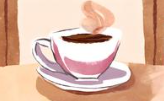